In [1]:
import serial
import numpy as np
import matplotlib.pyplot as plt
import time
import statistics
import os.path
import pickle # para leer los archivos comprimidos (.p)
import scipy.fft
from scipy.optimize import curve_fit
from IPython import embed


COM_ARDUINO_MEGA = 'COM6' # Puertos Serie
COM_ARDUINO_UNO = 'COM3'
baudrate_arduino= 250000 
SampleFreq=2 #kHz
tiempo_adq = 2 #seg
cantidad_samples = SampleFreq*tiempo_adq*1000   #1min 120 000
nombreArchivo = './datos/de1.p'# nombre del archivo donde guardar los datos


def leer_sensor(arduino_puerto_serie,cantidad_samples):
    samples_sensor0 = np.zeros((cantidad_samples))
    samples_sensor1 = np.zeros((cantidad_samples))
    i = 0
    arduino.reset_input_buffer()
    for n_samples in range(0,cantidad_samples):
        read_val = False
        splitted = ""
        while not read_val:
            try:
                line = arduino.readline()
                string_n = line.decode()  # decode byte string into Unicode  
                string = string_n.rstrip() # remove \n and \r
                string_splitted = string.split(",")
                samples_sensor0[n_samples] = float(string_splitted[0])
                samples_sensor1[n_samples] = float(string_splitted[1])
                read_val = True
                #print(i)
                #i+=1
            except ValueError:
                #print("Línea con error: {}".format(line))
    return samples_sensor0, samples_sensor1


def guardar_datos(nombreArchivo, datos):
    # comprueba si el archivo existe
    if os.path.exists(nombreArchivo):
        print("El archivo %s ya existe. Renombrando..." %nombreArchivo)
        # chequear version
        v = 0
        path = os.path.split(nombreArchivo)[0]
        raw = os.path.splitext(os.path.split(nombreArchivo)[1])[0]
        ext = os.path.splitext(os.path.split(nombreArchivo)[1])[1]
        if len(raw.split('_')) < 2:
            v += 1
            new = raw + '_'+str(v)+ext
        else:
            v = int(raw.split('_')[1]) + 1
            new = raw.split('_')[0]+'_'+str(v)+ext
        nombreArchivo = os.path.join(path, new)
    with open(nombreArchivo, 'wb') as f:
        pickle.dump(datos, f)
        print("Datos guardados en %s" %nombreArchivo)
        f.close()
    return nombreArchivo

IndentationError: expected an indented block (2333583302.py, line 43)

In [2]:
# Abrimos la conexión con Arduino
# Hack cortesía de https://www.oreilly.com/library/view/python-cookbook/0596001673/ch17s02.html
try: arduino
except NameError:
    arduino = serial.Serial(COM_ARDUINO_UNO, baudrate=baudrate_arduino, timeout=1.0)
if not arduino.is_open: arduino.open()
arduino.setDTR(False)
time.sleep(1)
arduino.flushInput()
arduino.setDTR(True)
#adquiero
print('adquiriendo...')
[samples_sensor0, samples_sensor1] = leer_sensor(arduino,cantidad_samples)

# creo un diccionario para guardar mis datos
samples = {'sensor0' : samples_sensor0,
           'sensor1' : samples_sensor1}    
nombreArchivo = guardar_datos(nombreArchivo, samples)

Línea con error: b''
El archivo ./datos/de1.p ya existe. Renombrando...
Datos guardados en ./datos\de1_1.p


Datos extraidos de ./datos\de1_1.p


<IPython.core.display.Javascript object>


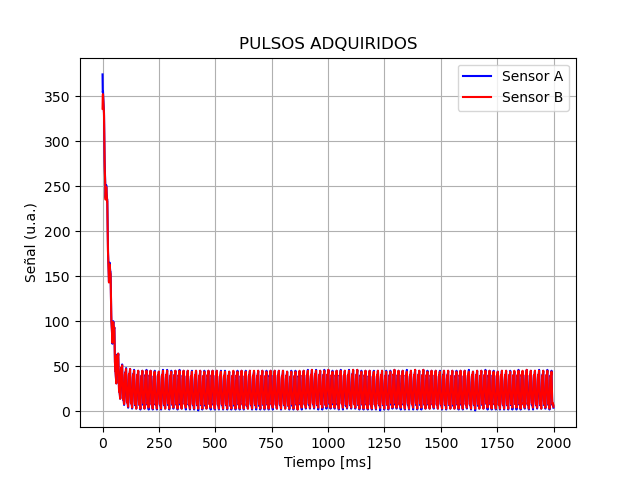

Valor medio Señal Sensor0: 27.62
Valor medio Señal Sensor1: 27.89


<IPython.core.display.Javascript object>


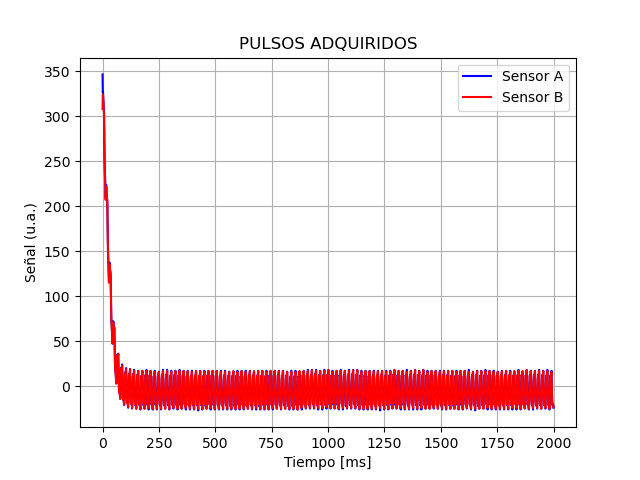

Valor maximo Señal Sensor0: 346.38
Valor maximo Señal Sensor1: 324.11


<IPython.core.display.Javascript object>


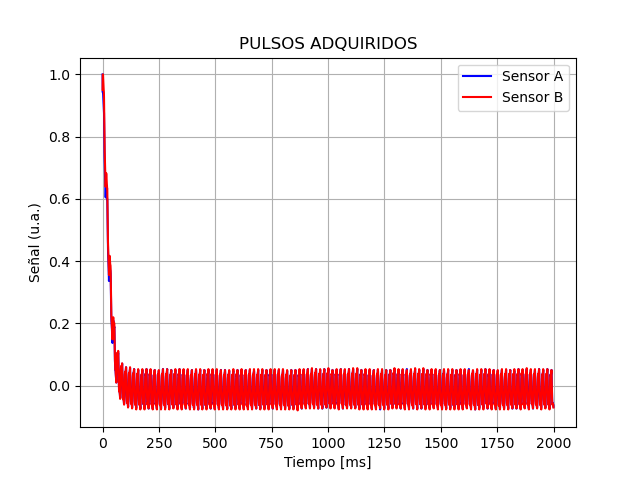

In [4]:

with open(nombreArchivo, 'rb') as f:
    samples = pickle.load(f)
    print("Datos extraidos de %s" %nombreArchivo)
    f.close()
    
%matplotlib notebook

time = np.arange(0,cantidad_samples/SampleFreq,1/SampleFreq)
#time = np.linspace(0,samples_sensor0[250:].size/100,samples_sensor0[250:].size)

#%matplotlib notebook 
#vemos grafico en detalle iteractivo 

# leo los datos
#archivoLectura = nombreArchivo #archivoLectura = './datos/o2.p'

#samples = leer_datos(archivoLectura)


samples_sensor0 = samples['sensor0']
samples_sensor1 = samples['sensor1']
# grafico de muestras completas
fig = plt.figure()
#plt.plot(time[10:],samples_sensor0[10:], 'b-', label="sensor extremo")
#plt.plot(time[10:],samples_sensor1[10:], 'r-', label="sensor base")
plt.plot(time,samples_sensor0, 'b', label="Sensor A")
plt.plot(time,samples_sensor1, 'r', label="Sensor B")
plt.xlabel("Tiempo [ms]")
plt.ylabel("Señal (u.a.)")
plt.title("PULSOS ADQUIRIDOS")
plt.legend()
#plt.xlim([1000,30000])
plt.grid()
plt.show()


# calculo media de los datos
mean_sensor0 = np.mean(samples_sensor0)
mean_sensor1 = np.mean(samples_sensor1)
print("Valor medio Señal Sensor0: %.2f" %mean_sensor0)
print("Valor medio Señal Sensor1: %.2f" %mean_sensor1)

# resto el valor medio a mis datos
samples_sensor0 -= mean_sensor0
samples_sensor1 -= mean_sensor1

fig = plt.figure()
#plt.plot(time[10:],samples_sensor0[10:], 'b-', label="sensor extremo")
#plt.plot(time[10:],samples_sensor1[10:], 'r-', label="sensor base")
plt.plot(time,samples_sensor0, 'b', label="Sensor A")
plt.plot(time,samples_sensor1, 'r', label="Sensor B")
plt.xlabel("Tiempo [ms]")
plt.ylabel("Señal (u.a.)")
plt.title("PULSOS ADQUIRIDOS")
plt.legend()
#plt.xlim([1000,30000])
plt.grid()
plt.show()

# normalizo los datos.
# obtengo valor maximo de cada señal y divido con respecto a ese valor
max_samples_sensor0 = np.max(samples_sensor0)
max_samples_sensor1 = np.max(samples_sensor1)
print("Valor maximo Señal Sensor0: %.2f" %max_samples_sensor0)
print("Valor maximo Señal Sensor1: %.2f" %max_samples_sensor1)
samples_sensor0 /= max_samples_sensor0
samples_sensor1 /= max_samples_sensor1

fig = plt.figure()
#plt.plot(time[10:],samples_sensor0[10:], 'b-', label="sensor extremo")
#plt.plot(time[10:],samples_sensor1[10:], 'r-', label="sensor base")
plt.plot(time,samples_sensor0, 'b', label="Sensor A")
plt.plot(time,samples_sensor1, 'r', label="Sensor B")
plt.xlabel("Tiempo [ms]")
plt.ylabel("Señal (u.a.)")
plt.title("PULSOS ADQUIRIDOS")
plt.legend()
#plt.xlim([1000,30000])
plt.grid()
plt.show()

